# MNIST - Conv-Autoencoder and Clustering

## Dependencies

In [20]:
# import
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL
import sklearn.cluster as cluster
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm
import visdom
import warnings

In [2]:
# apply settings
%matplotlib inline
np.random.seed(43)
warnings.filterwarnings('ignore')

## Data

In [3]:
# download MNIST data and apply transformations
train_dataset = datasets.MNIST(root = 'mnist', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = 'mnist', train = False, transform = transforms.ToTensor(), download = True)

In [4]:
# split dataset into unsupervised and supervised sets - 5000 and 1000 images per class, respectively
unsup_dataset, sup_dataset = data.random_split(train_dataset, (50000, 10000))

In [5]:
# split 10 images from sup_dataset for image generation - gen_dataset
gen_dataset, _ = data.random_split(sup_dataset, (10, 10000 - 10))

In [6]:
# create dataloaders
unsup_loader = data.DataLoader(unsup_dataset, batch_size = 32, shuffle = True)
gen_loader = data.DataLoader(gen_dataset, batch_size = 1, shuffle = True)

## Autoencoder

In [7]:
# define encoder
class Encoder(nn.Module):
    '''conv. feed forward nn'''
    def __init__(self):
        '''constructor'''
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, 3, padding = 1)
        
    def forward(self, x):
        '''forward prop.'''
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        return x

In [8]:
# define decoder
class Decoder(nn.Module):
    '''deconv. feed forward nn'''
    def __init__(self):
        '''constructor'''
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(8, 16, 2, stride = 2)
        self.deconv2 = nn.ConvTranspose2d(16, 1, 2, stride = 2)
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        
    def forward(self, x):
        '''forward prop.'''
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv1(x))

        return x

### Architecture

In [9]:
# define model
class Model(nn.Module):
    '''conv. autoencoder'''
    def __init__(self):
        '''constructor'''
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        '''forward prop.'''
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

### Training

In [10]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}\n'.format(device))

device: cuda:0



In [11]:
# instantiate model
model = Model().to(device)

In [12]:
# define loss function, optimizer and learning rate scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 0, verbose = False)

epoch 1 of 10

initial training loss: 0.78
training loss: 0.11

epoch 2 of 10

initial training loss: 0.08
training loss: 0.08

epoch 3 of 10

initial training loss: 0.08
training loss: 0.08

epoch 4 of 10

initial training loss: 0.08
training loss: 0.08

epoch 5 of 10

initial training loss: 0.08
training loss: 0.08

epoch 6 of 10

initial training loss: 0.08
training loss: 0.08

epoch 7 of 10

initial training loss: 0.08
training loss: 0.08

epoch 8 of 10

initial training loss: 0.08
training loss: 0.08

epoch 9 of 10

initial training loss: 0.08
training loss: 0.08

epoch 10 of 10

initial training loss: 0.08
training loss: 0.08

original image


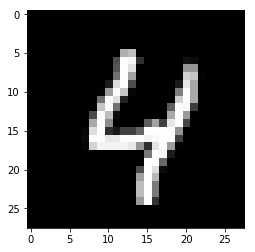

generated image


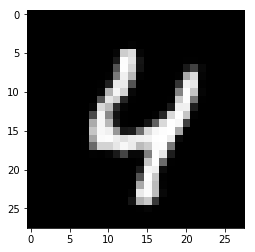

original image


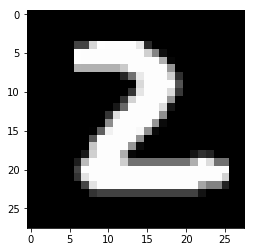

generated image


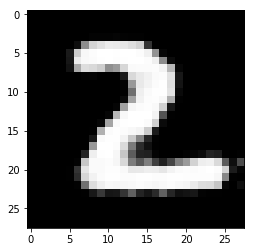

original image


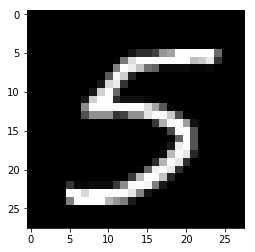

generated image


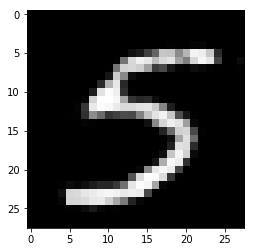

original image


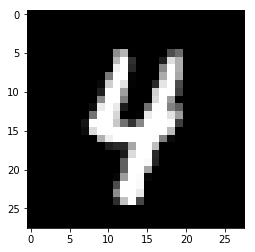

generated image


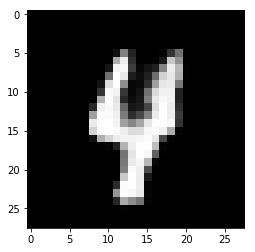

original image


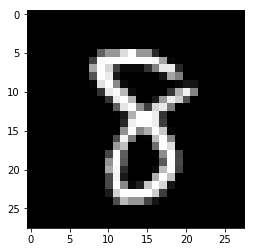

generated image


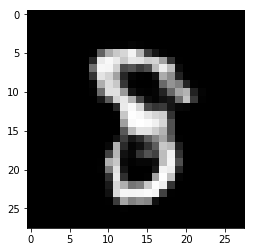

original image


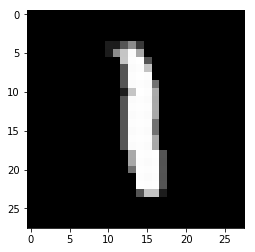

generated image


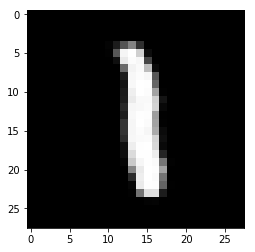

original image


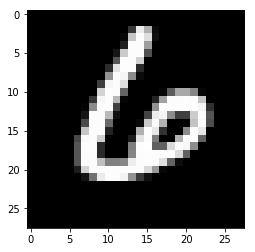

generated image


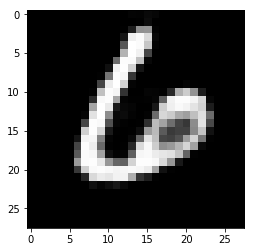

original image


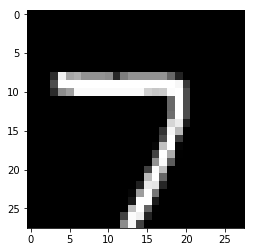

generated image


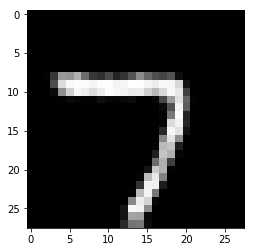

original image


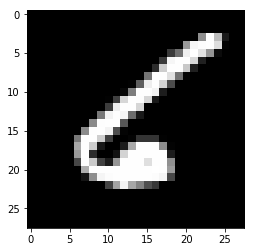

generated image


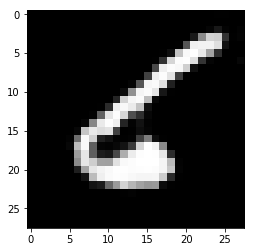

original image


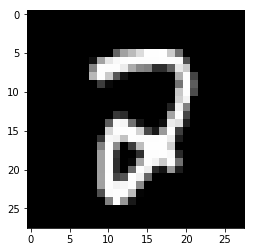

generated image


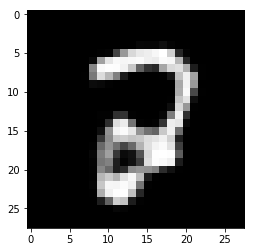

In [13]:
# train model      
for epoch in range(1, 11):
    print('epoch {} of 10\n'.format(epoch))
    batch_idx = None
    running_loss = 0
    for batch_idx, data_ in enumerate(unsup_loader):
        inputs, _ = data_
        inputs = inputs.to(device)

        # optimize
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print initial train loss
        if batch_idx == 0:
            print('initial training loss: {:.2f}'.format(loss.item()))

    # print epoch end loss
    print('training loss: {:.2f}\n'.format(running_loss / (batch_idx + 1)))
    
    # generate few images
    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            for img_id, data_ in enumerate(gen_loader):        
                img, _ = data_
                img = img.to(device)

                print('original image')
                plt.imshow(img.cpu().numpy()[0][0], cmap = 'gray')
                plt.show()

                print('generated image')
                gen_img = model(img)
                plt.imshow(gen_img.detach().cpu().numpy()[0][0], cmap = 'gray')
                plt.show()
                
            model.train()

## Clustering

In [55]:
# create new unsup_loader with batch_size = 1
unsup_loader_1 = data.DataLoader(unsup_dataset, batch_size = 1, shuffle = True)

In [56]:
# get unsupervised dataset encodings
encodings = []

with torch.no_grad():
    model.eval()
    for img_idx, data_ in enumerate(unsup_loader_1):
        img, _ = data_
        img = img.to(device)
        
        enc = model.encoder(img)
        enc = enc.flatten().tolist()

        encodings.append(enc)

encodings = np.array(encodings)

In [59]:
# cluster encodings
kmeans = cluster.MiniBatchKMeans(n_clusters = 10, max_iter = 100, random_state = 43)
kmeans.fit(encodings)
clusters = kmeans.cluster_centers_

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=43, reassignment_ratio=0.01, tol=0.0,
        verbose=0)